# Graded Exercise - Week 3

Building on CW02_part2,  we will use the given chirped binary diffraction grating as a spectrometer. Around the center wavelength of 633 $nm$,

a) find the wavelength band that this spectrometer can measure by using the first order of diffraction within the given simulation window and with the absorptive boundary condition.

b) calculate the wavelength resolution of such a spectrometer in its working band.

c) explain the found values theoretically and propose ways to improve the bandwidth and resolution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
array_size = 300e-6  
num_pixels = 512  # Resolution

dx = array_size / num_pixels  # Pixel size

wvl = 633e-9
dz = 30e-6


# Create spatial coordinate grid
x = np.linspace(-array_size / 2, array_size / 2, num_pixels)
y = np.linspace(-array_size / 2, array_size / 2, num_pixels)
X, Y = np.meshgrid(x, y)

In [3]:
def angular_spectrum_propagation_range(U0, wvl, dx, dz, num_steps, absorptive_boundary= False):
    """
    Propagates an optical field using the Angular Spectrum Method over a range of distances.

    Parameters:
        U0      : 2D numpy array (input wavefield)
        wvl     : float (wavelength of light in meters)
        d_range : list or numpy array (range of propagation distances in meters)
        dx      : float (sampling interval in meters)

    Returns:
        U_list  : list of 2D numpy arrays (propagated wavefields for each distance in d_range)
    """
    
    # Get array size
    ny, nx = U0.shape
    k = 2 * np.pi / wvl  # Wave number

    # Create spatial frequency coordinates
    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)
    FX, FY = np.meshgrid(fx, fy)
    
    # Initialize list to store results
    U_list = []
    
    # Apply super Gaussian absorptive boundary

    if absorptive_boundary:
        sigma = nx/3.5  # Standard deviation for Gaussian
        X, Y = np.meshgrid(np.linspace(-nx/2, nx/2, nx), np.linspace(-ny/2, ny/2, ny))
        window = np.exp(-((X**2 + Y**2) / (2 * sigma**2))**4)
    else:
        window = np.ones_like(U0)
        
    H = np.exp(1j * k * dz * np.sqrt(0j+ 1 - (wvl * FX) ** 2 - (wvl * FY) ** 2))

    for _ in range(num_steps):
        
        # Apply transfer function
        U_spectrum = np.fft.fft2(U0) * H
        
        # Inverse FFT to obtain propagated field
        U0 = np.fft.ifft2(U_spectrum)
        U0 *= window
        U_list.append(U0)
        
    return U_list


In [4]:
grating_period = 8e-6
grating_width = 100e-6
chirp_term = 0.05
prop_distance = 1e-3
prop_steps = np.round(prop_distance / dz).astype(int)


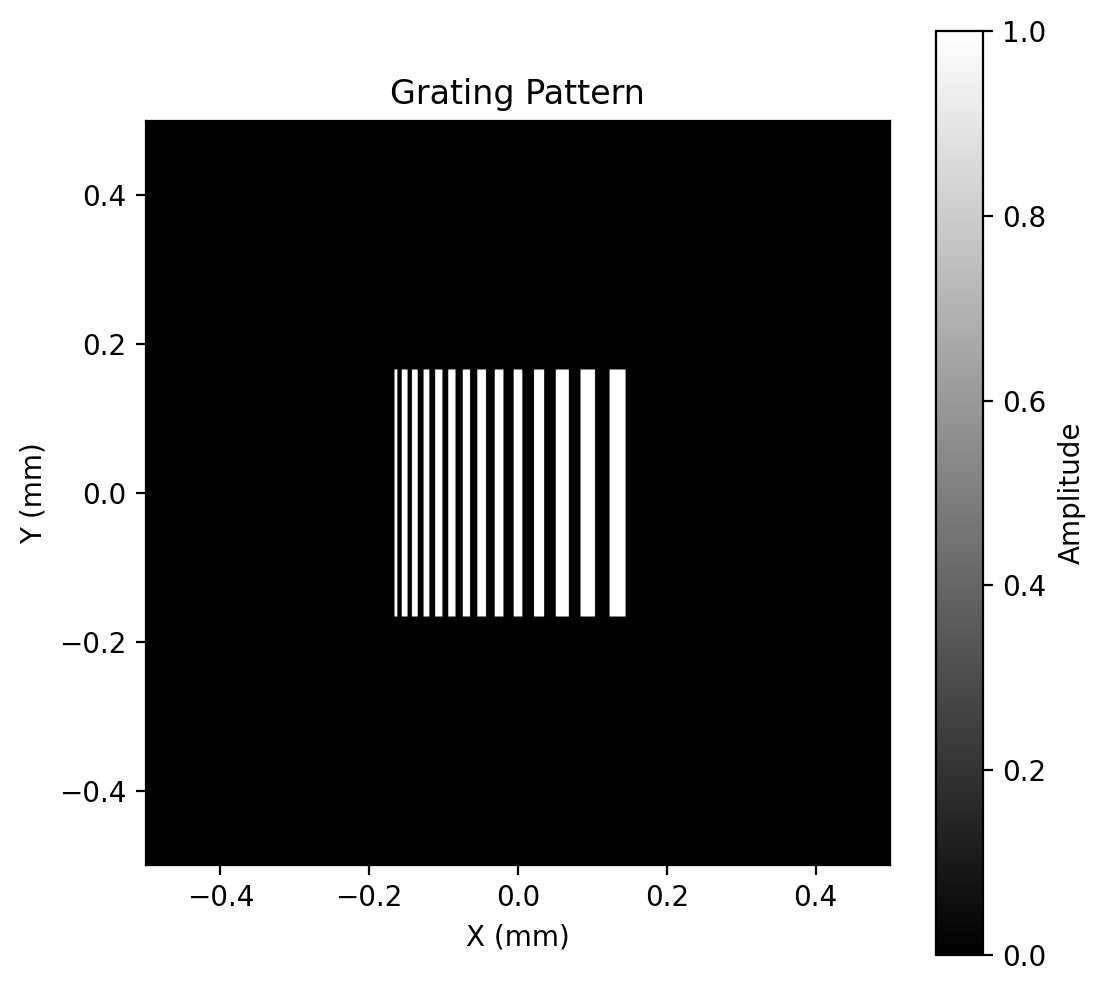

In [5]:
aperture = (np.abs(X) < (grating_width / 2)) * (np.abs(Y) < (grating_width / 2))

grating = (np.cos( 2 * np.pi * X/ (grating_period+ chirp_term*X)) > 0 ) * aperture

# Display the grating
plt.figure(figsize=(6, 6),dpi = 200)
plt.imshow(grating, cmap="gray", extent=[-0.5, 0.5, -0.5, 0.5])
plt.colorbar(label="Amplitude")
plt.title("Grating Pattern")
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.show()


In [6]:
wavelenghth_range = np.linspace(-200e-9,200e-9,30) + wvl
out_fields = []
for cur_wl in wavelenghth_range:
    grating_zs = angular_spectrum_propagation_range(grating, cur_wl, dx, dz, prop_steps, True)
    out_fields.append(grating_zs[-1])
array_3d = np.stack(out_fields, axis=0)

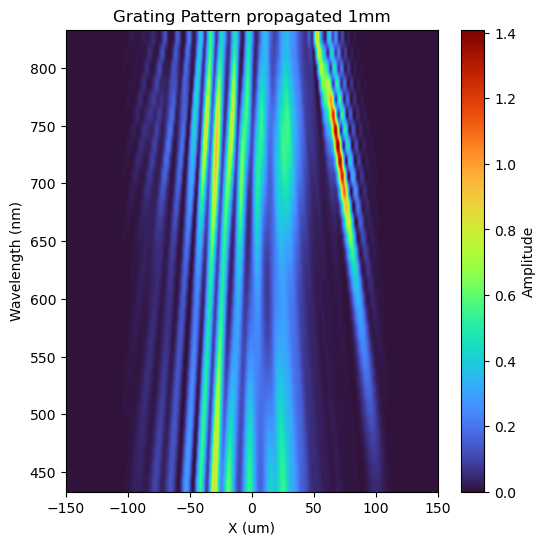

In [23]:
# Display the grating
plt.figure(figsize=(6, 6))

plt.imshow(np.abs(array_3d[:, 256, :])**2, cmap="turbo",aspect = 'auto', extent=[-array_size/2*1e6, array_size/2*1e6, wavelenghth_range[0]*1e9, wavelenghth_range[-1]*1e9])
plt.colorbar(label="Amplitude")
plt.title("Grating Pattern propagated 1mm")
plt.xlabel("X (um)")
plt.ylabel("Wavelength (nm)")
plt.show()

a) According to the previous plot, we can estimate the operating spectrum to be between 550-850 nanometers.


plt.plot(np.linspace(-num_pixels/2, num_pixels/2, num_pixels)*dx*1e6, np.abs(array_3d[10, 256, :])**2)
plt.plot(np.linspace(-num_pixels/2, num_pixels/2, num_pixels)*dx*1e6, np.abs(array_3d[13, 256, :])**2)
plt.xlabel("X (um)")
plt
print((wavelenghth_range[13]-wavelenghth_range[10])*1e9)

41.379310344827594


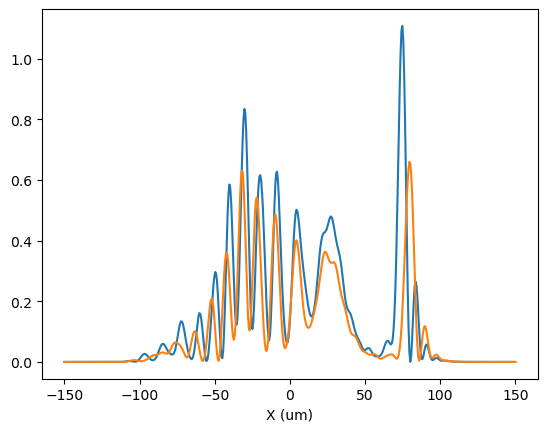

In [24]:
plt.plot(np.linspace(-num_pixels/2, num_pixels/2, num_pixels)*dx*1e6, np.abs(array_3d[10, 256, :])**2)
plt.plot(np.linspace(-num_pixels/2, num_pixels/2, num_pixels)*dx*1e6, np.abs(array_3d[13, 256, :])**2)
plt.xlabel("X (um)")
print((wavelenghth_range[13]-wavelenghth_range[10])*1e9)

b) The closest resolvable peaks belong to wavelengths that are approximately 40 nanometers apart.

c) The resolving power of the grating depends on the number of grooves in the grating. The larger number of grooves create sharper diffraction peaks, where resolution can be estimated as $\Delta \lambda = \frac{\lambda}{N}$, where $N$ is the number of grooves in the grating. For $N = 14$ and $\lambda = 633 nm $ in our case, expected $\Delta \lambda = 45 nm$ is comparable to the estimated value of $40 nm$ from the simulation.

The observable bandwidth depends on the minimum wavelength with which the 1st diffraction order is discernable and the maximum wavelength that creates a diffraction order that can reach to the detector. In our case, the effective aperture has about $100 \mu m$ and propagation distance is 1 mm. Then the simulation NA is about 0.1 which means the maximum wavelength is $ 0.1< \frac{\lambda_{max}}{\Lambda_{grating}}$ resulting in approximately $\lambda_{max} = 800 nm$. The minimum discernible wavelength depends on the grating size and period. 

According to this analysis, using a larger grating can improve wavelength resolution and the simulation can reach to the theoretical limit of wavelength range by selecting a larger simulation window in exchange with computational cost.